In [1]:
import pandas as pd
import numpy as np
import re
import string

from scrapy.selector import Selector
from scrapy.http import HtmlResponse
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, minmax_scale, OneHotEncoder
from sklearn.compose import ColumnTransformer

import warnings   # do not show warnings
warnings.filterwarnings('ignore')

# Web Scraping

In [2]:
# # the scope of search is limited to data related jobs. The url for each page is put in a list

# # the home page
# homepage = 'https://au.indeed.com'
# # the url for the different pages of the website (the pattern of the url has been previously checked)
# page_url = [homepage + "/jobs?q=data&start=" + str((page_num-1)*10) for page_num in range(1, 401)]

# # the list containing all the values of a feature
# titles = []
# departments = []
# salaries = []
# locations = []
# employment_types = []
# post_times = []
# review_stars = []
# review_numbers = []
# descriptions = []
# page_contents = []

# # the xpath of a feature
# xpath_links = './/*[@data-tn-element="jobTitle"]/@href'
# xpath_titles = '/html/body/div[1]/div[2]/div[3]/div/div/div[1]/div[1]/div[1]/h3/text()'
# xpath_departments = '/html/body/div[1]/div[2]/div[3]/div/div/div[1]/div[1]/div[1]/div[1]/div/div/div[1]/a/text()'
# xpath_salaries = '/html/body/div[1]/div[2]/div[3]/div/div/div[1]/div[1]/div[1]/div[2]/span/text()'
# xpath_locations = '/html/body/div[1]/div[2]/div[3]/div/div/div[1]/div[1]/div[3]/div[1]/div[1]/span/text()'
# xpath_employment_types = '/html/body/div[1]/div[2]/div[3]/div/div/div[1]/div[1]/div[3]/div[1]/div[2]/span/text()'
# xpath_post_times = '/html/body/div[1]/div[2]/div[3]/div/div/div[1]/div[1]/div[4]/div[1]/text()'
# xpath_review_stars = '/html/body/div[1]/div[2]/div[3]/div/div/div[1]/div[1]/div[1]/div[1]/div/div/div[2]/div/a/@aria-label'
# xpath_review_numbers = '/html/body/div[1]/div[2]/div[3]/div/div/div[1]/div[1]/div[1]/div[3]/a/div/div/div[1]/div[1]/div[2]/text()'
# xpath_descriptions = '//*[@id="jobDescriptionText"]/p'
# xpath_page_contents = '/html/body'


# # we go through all the pages and within each page, we check the job through their link
# for page in page_url:
#     response = requests.get(page)
#     HTML = response.text
#     xpath_selector = Selector(text=HTML)
#     links = xpath_selector.xpath(xpath_links).extract()
#     links = [homepage + link for link in links]   # putting all links of a page in a list
#     for link in links:
#         response_details = requests.get(link)
#         HTML_details = response_details.text
#         xpath_selector_details = Selector(text=HTML_details)

#         # in each job advertisement, we extract the feature if it exists, otherwise, we assign null to the value 
#         try:
#             job_title = xpath_selector_details.xpath(xpath_titles).extract()[0].strip()
#         except:
#             job_title = np.nan
            
#         try:
#             job_department = xpath_selector_details.xpath(xpath_departments).extract()[0].strip()
#         except:
#             job_department = np.nan

#         try:
#             job_salary = xpath_selector_details.xpath(xpath_salaries).extract()[0].strip()
#         except:
#             job_salary = np.nan
            
#         try:
#             job_location = xpath_selector_details.xpath(xpath_locations).extract()[0].strip()
#         except:
#             job_location = np.nan  
        
#         try:
#             job_employment_type = xpath_selector_details.xpath(xpath_employment_types).extract()[0].strip()
#         except:
#             job_employment_type = np.nan    
            
#         try:
#             job_post_time = xpath_selector_details.xpath(xpath_post_times).extract()[0].strip()
#         except:
#             job_post_time = np.nan
            
#         try:
#             job_review_star = xpath_selector_details.xpath(xpath_review_stars).extract()[0].strip()
#         except:
#             job_review_star = np.nan    
             
#         try:
#             job_review_number = xpath_selector_details.xpath(xpath_review_numbers).extract()[0].strip()
#         except:
#             job_review_number = np.nan
        
#         try:
#             job_description = xpath_selector_details.xpath(xpath_descriptions).extract()
#         except:
#             job_description = np.nan
            
#         try:
#             job_page_content = xpath_selector_details.xpath(xpath_page_contents).extract()
#         except:
#             job_page_content = np.nan
        
#         # now that we have extracted all the features in a job advertisement, we appned them to the corresponding list 
#         titles.append(job_title)
#         departments.append(job_department)
#         salaries.append(job_salary)
#         locations.append(job_location)
#         employment_types.append(job_employment_type)
#         post_times.append(job_post_time)
#         review_stars.append(job_review_star)
#         review_numbers.append(job_review_number)
#         descriptions.append(job_description)
#         page_contents.append(job_page_content)

In [3]:
# # creating a dataframe of all the extracted data
# jobs_original = pd.DataFrame(data={'title':titles,
#                          'department':departments,
#                          'salary':salaries,
#                          'location':locations,
#                          'employment_type':employment_types,
#                          'post_time':post_times,
#                          'review_star':review_stars,
#                          'review_number':review_numbers,
#                          'description':descriptions,
#                          'page_content':page_contents})

In [4]:
# # saving the data frame as a csv file
# jobs_original.to_csv('jobs_original.csv')

# Cleaning

In [5]:
# reading the csv file
jobs = pd.read_csv('jobs_original.csv')

In [6]:
# dropping the column which is the same as the index
jobs.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
# dropping the duplicates
jobs.drop(index=jobs[jobs.duplicated()].index, axis=0, inplace=True)

In [8]:
# turning all values into lower case string
jobs = jobs.apply(lambda x: x.astype(str).str.lower())

In [9]:
# function for turning review_star values into numbers
def extract_star(x):
    if x != 'nan':
        return float(re.findall('^\d*\.?\d*', x)[0])
    else:
        return np.nan

In [10]:
# function for turning review_number values into numbers
def extract_review(x):
    if x != 'nan':
        return float((re.findall('(^\d*.\d*)', x)[0]).replace(',', ''))
    else:
        return np.nan

In [11]:
# function for extracting salary values from salary
def extract_salary(x, segment):
    if len(re.findall('([\d+.\d+,]+)[\s+].*\s([a-zA-Z]+)', x)) != 0:
        if segment == 'value':
            if len(re.findall('- \$(\d+.\d+).*', x)) == 0:
                try:
                    return float(re.findall('([\d+.\d+,]+)[\s+].*\s([a-zA-Z]+)', x)[0][0].replace(',', ''))
                except:
                    pass
            else:
                try:
                    # if there is a range for salary, take the mean as the salary value
                    return 0.5 * (float(re.findall('- \$(\d+.\d+).*', x)[0].replace(',', '')) +
                                 float(re.findall('([\d+.\d+,]+)[\s+].*\s([a-zA-Z]+)', x)[0][0].replace(',', '')))
                except:
                    pass
        elif segment == 'unit':
            return re.findall('([\d+.\d+,]+)[\s+].*\s([a-zA-Z]+)', x)[0][1]
    else:
        return np.nan

In [12]:
# function for extracting the name of the state from location
def extract_state(x):
    if 'vic' in x or 'victoria' in x:
        return 'vic'
    if 'nsw' in x or 'new south wales' in x:
        return 'nsw'
    if 'qld' in x or 'queensland' in x:
        return 'qld'
    if 'wa' in x or 'western australia' in x:
        return 'wa'
    if 'sa' in x or 'south australia' in x:
        return 'sa'
    if 'tas' in x or 'tasmania' in x:
        return 'tas'
    if 'act' in x or 'australian capital territory' in x:
        return 'act'
    if 'nt' in x or 'northern territory' in x:
        return 'nt'
    if 'australia' in x:
        return 'aus'
    else:
        return np.nan

In [13]:
# function for extracting the employment type
types_of_employment = []
for val in jobs.employment_type.unique():
    if len(re.findall('(\d+)', val)) == 0 and val!= 'nan':   # if it does not have a number (i.e. salary) in it
        types_of_employment.append(val)
        
def extraxt_employment(x):
    if x in types_of_employment:
        return x
    else:
        return np.nan

In [14]:
# function for extracting the job description from the html
def extract_description(x):
    soup = BeautifulSoup(x, 'lxml')
    element = soup.find(name='div', attrs={'id':'jobdescriptiontext'})
    return element.text.replace('\\n\\n',' ').replace('\\n',' ')

In [15]:
# since the salary is in different units, we need a function to estimate the annual salary
def to_annual(salary, unit):
    if unit == 'hour':
        return salary*2000
    elif unit == 'day':
        return salary*250
    elif unit == 'week':
        return salary*50
    elif unit == 'month':
        return salary*12
    elif unit == 'year':
        return salary
    else:
        return np.nan

In [16]:
# function for categorizing annual_salary
def salary_cat(x):
    if x<jobs.annual_salary.median():
        return 'low'
    elif x>=jobs.annual_salary.median():
        return 'high'
    else:
        return np.nan

In [17]:
# turning review_star values into numbers
jobs['review_star'] = jobs.review_star.map(extract_star)

In [18]:
# turning review_number values into numbers
jobs['review_number'] = jobs.review_number.map(extract_review)

In [19]:
# extracting the salary values from salary
jobs['salary_value'] = jobs.salary.map(lambda x: extract_salary(x, 'value'))
jobs['salary_unit'] = jobs.salary.map(lambda x: extract_salary(x, 'unit'))
jobs.drop('salary', axis=1, inplace=True)

In [20]:
# extracting the state values from location
jobs['state'] = jobs.location.map(extract_state)

In [21]:
# locations that do not fall into any state
jobs.location[jobs.state.isnull()].unique()

array(['home based'], dtype=object)

In [22]:
jobs[jobs.location=='home based']

,title,department,location,employment_type,post_time,review_star,review_number,description,page_content,salary_value,salary_unit,state
1185,cra ii,nan,home based,nan,- 19 days ago,NaN,NaN,[],"['<body>\n <script type=""text/javascript"" s...",NaN,NaN,NaN
1406,sr cra i,nan,home based,nan,- 19 days ago,NaN,NaN,[],"['<body>\n <script type=""text/javascript"" s...",NaN,NaN,NaN


In [23]:
# dropping the rows with home-based location since they don't give us any information
jobs.drop(index=jobs[jobs.location=='home based'].index, inplace=True)

In [24]:
jobs['employment_type'] = jobs.employment_type.map(extraxt_employment)

In [25]:
# dropping post_time since it is not useful
jobs.drop('post_time', axis=1, inplace=True)

In [26]:
# dropping description since it is not useful
jobs.drop('description', axis=1, inplace=True)

In [27]:
# demonstrating an example of a job description
from IPython.core.display import HTML

HTML(jobs.page_content[150])

In [28]:
# extracting the description from page content
jobs['description'] = jobs.page_content.map(extract_description)

In [29]:
# dropping page_content since we do not need it anymore
jobs.drop('page_content', axis=1, inplace=True)

In [30]:
# substituting all the empty departments with NaN
jobs.department = jobs.department.map(lambda x: np.nan if x == 'nan' else x)

In [31]:
# dropping the duplicated rows
jobs.drop(index=jobs[jobs.duplicated()].index, inplace=True)

In [32]:
# resetting the index
jobs.reset_index(drop=True, inplace=True)

In [33]:
# # saving the clean data as a csv file
# jobs.to_csv('jobs_clean.csv')

In [34]:
# # making a column of annual salaries
# jobs['annual_salary'] = jobs.salary_value
# for ind in range(jobs.salary_value.shape[0]):
#     jobs['annual_salary'][ind] = to_annual(jobs.salary_value[ind], jobs.salary_unit[ind])

In [35]:
# # saving the clean data as a csv file
# jobs.to_csv('jobs_clean_with_annual_salary.csv')

# Preprocessing and EDA

In [36]:
jobs = pd.read_csv('jobs_clean_with_annual_salary.csv').drop('Unnamed: 0', axis=1)

In [37]:
# categorizing the annual salary
jobs['salary_cat'] = jobs.annual_salary.map(salary_cat)

In [38]:
median_salary = jobs.annual_salary.median()
print('The median of salary is:', median_salary)

The median of salary is: 69316.25


(array([23., 90., 77., 36.,  9.,  8.,  2.,  6.,  4.,  3.]),
 array([ 22000.,  43450.,  64900.,  86350., 107800., 129250., 150700.,
        172150., 193600., 215050., 236500.]),
 <a list of 10 Patch objects>)

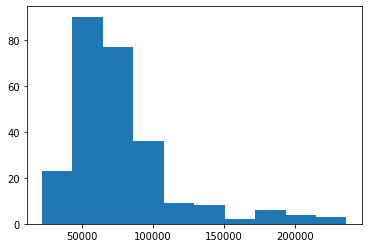

In [39]:
# histogram of the annual salary
plt.hist(jobs.annual_salary)

In [40]:
# number of jobs in each category of salary
jobs.salary_cat.value_counts()

high    129
low     129
Name: salary_cat, dtype: int64

In [41]:
# removing punctuation
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    try:
        for punc in PUNCT_TO_REMOVE:
            text = text.replace(punc, ' ')
        return text
    except:
        return np.nan

jobs[['title', 'department', 'location', 'employment_type', 'description']] =\
jobs[['title', 'department', 'location', 'employment_type', 'description']].applymap(lambda text: remove_punctuation(text))

In [42]:
# defining the stop words
STOPWORDS = set(stopwords.words('english'))

# function for removing the stop words
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

# removing the stop words
jobs['title'] = jobs['title'].apply(lambda text: remove_stopwords(text))
jobs['description'] = jobs['description'].apply(lambda text: remove_stopwords(text))

In [43]:
# stemming the text of description
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

jobs["description"] = jobs["description"].apply(lambda text: stem_words(text))

In [44]:
# finding the frequency of the words in the description
cnt = Counter()
for text in jobs["description"].values:
    for word in text.split():
        cnt[word] += 1

# removing the top 10 frequent words from the description
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

jobs["description"] = jobs["description"].apply(lambda text: remove_freqwords(text))

# removing the 10 least frequent words from the description
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

jobs["description"] = jobs["description"].apply(lambda text: remove_rarewords(text))

# Imputing the missing data

In [45]:
# setting the job title as a predictor and the annual salary as the target for jobs with known salary
data = jobs[~jobs.annual_salary.isnull()]
y = jobs[~jobs.annual_salary.isnull()]['annual_salary']

data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.4, random_state=0)

model = make_pipeline(CountVectorizer(ngram_range=(1, 3)), LinearRegression())
model.fit(data_train.title, y_train)
y_pred = model.predict(data_test.title)
print('The mean score of model:', cross_val_score(model, data_test.title, y_test, cv=5).mean())

The mean score of model: -0.4668788251208104


Since filling in the missing rows with th mean keeps the mean of data unchanged and also since the model does not predict the salary better than the baseline, we impute the missing data with the mean.

In [46]:
# imputing missing data with the mean
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
jobs.annual_salary = imp_mean.fit_transform(np.array(jobs.annual_salary).reshape(-1,1))

In [47]:
# function for categorizing annual_salary using the same median value as before imputing data
def salary_cat(x):
    if x<median_salary:
        return 'low'
    elif x>=median_salary:
        return 'high'
    else:
        return np.nan

# categorizing the annual salary
jobs['salary_cat'] = jobs.annual_salary.map(salary_cat)

Since we might use the department as a feature later, we impute the missing data for that with the word 'missing'

In [48]:
imp_miss = SimpleImputer(strategy='constant', fill_value='missing')
jobs.department = imp_miss.fit_transform(np.array(jobs.department).reshape(-1,1))

# Modeling and prediction of salary

In [49]:
# setting the job title as a predictor and the categorized salary as the target
data = jobs
y = jobs.salary_cat

In [50]:
jobs.salary_cat.value_counts()

high    861
low     129
Name: salary_cat, dtype: int64

In [51]:
# calculating the baseline
baseline_accuracy = jobs.salary_cat.value_counts().max()/jobs.salary_cat.value_counts().sum()
print('Baseline accuracy =', baseline_accuracy)

Baseline accuracy = 0.8696969696969697


We expected a baseline accuracy of 0.5 before imputing data since we categorized the salary based on the median of known data. Now the accuracy is high because most of the rows are filled with the mean. 

Now we make some models to predict the category of salary using the job titles.

In [52]:
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.4, stratify=y, random_state=0)

In [53]:
model = make_pipeline(CountVectorizer(ngram_range=(1, 3)), LogisticRegression())
model.fit(data_train.title, y_train)
scores = cross_val_score(model, data_test.title, y_test, cv=5)
sm = scores.mean()
ss = scores.std()
print("Average score with CountVectorizer: {:0.3} +/- {:0.3}".format(sm, ss))
print('------------------------------------------------')

model = make_pipeline(HashingVectorizer(ngram_range=(1, 3), non_negative=True, n_features=100), LogisticRegression())
model.fit(data_train.title, y_train)
scores = cross_val_score(model, data_test.title, y_test, cv=5)
sm = scores.mean()
ss = scores.std()
print("Average score with HashingVectorizer: {:0.3} +/- {:0.3}".format(sm, ss))
print("Number of features:", 100)
print('------------------------------------------------')

model = make_pipeline(TfidfVectorizer(ngram_range=(1, 3), sublinear_tf=True, max_features=100),
                      LogisticRegression())
model.fit(data_train.title, y_train)
scores = cross_val_score(model, data_test.title, y_test, cv=5)
sm = scores.mean()
ss = scores.std()
print("Average score with TfidfVectorizer: {:0.3} +/- {:0.3}".format(sm, ss))
print("Number of features:", len(model.steps[0][1].get_feature_names()))
print('------------------------------------------------')

model = make_pipeline(CountVectorizer(ngram_range=(1, 3)), SVC(kernel='linear'))
model.fit(data_train.title, y_train)
scores = cross_val_score(model, data_test.title, y_test, cv=5)
sm = scores.mean()
ss = scores.std()
print("Average score with SVC: {:0.3} +/- {:0.3}".format(sm, ss))

Average score with CountVectorizer: 0.861 +/- 0.00871
------------------------------------------------
Average score with HashingVectorizer: 0.869 +/- 0.00512
Number of features: 100
------------------------------------------------
Average score with TfidfVectorizer: 0.869 +/- 0.00512
Number of features: 100
------------------------------------------------
Average score with SVC: 0.843 +/- 0.0182


As we see the accuracy of the model is almost the same as the baseline accuracy. So we should either change our model or our predictors.

In [54]:
def search_model(classifier_name, classifier_parameters):
    
    # we create the preprocessing pipelines for categorical, numerical and text data

    numeric_features = ['review_star', 'review_number']
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])

    categorical_features = ['employment_type', 'state']
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    text_features = ['title', 'department', 'location', 'description']
    text_transformer = Pipeline(steps=[

        ('vectorizer', CountVectorizer(ngram_range=(1, 2)))])

    preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('txt1', text_transformer, text_features[0]),
            ('txt2', text_transformer, text_features[1]),
            ('txt3', text_transformer, text_features[2]),
            ('txt4', text_transformer, text_features[3])])

    # appending classifier to preprocessing pipeline.
    # now we have a full prediction pipeline.
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', classifier_name)])

    X = jobs.drop(['salary_value', 'salary_unit', 'annual_salary', 'salary_cat'], axis=1)
    y = jobs.salary_cat

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

    clf.fit(X_train, y_train)
    print("Model score: %.3f" % clf.score(X_test, y_test))

    # using grid search, we find the best model
    param_grid = {
        'preprocessor__num__imputer__strategy': ['mean', 'constant'],
        'preprocessor__txt4__vectorizer__ngram_range': [(1, 2), (1, 3)]}
    param_grid.update(classifier_parameters)


    grid_search = GridSearchCV(clf, param_grid, cv=10, iid=False)
    grid_search.fit(X_train, y_train)

    print('-----------------------------------------------------')
    print('Grid Search Results\n')
    print("Best parameters from grid search:", grid_search.best_params_)
    print("Best score from grid search:", grid_search.best_score_)
    print(("Score of the prediction of the test data: %.3f" % grid_search.score(X_test, y_test)))

Using grid search, we find the best model with different classifiers.

In [55]:
# # logistic regression
# parameters = {'classifier__C': [0.1, 1.0, 10, 100]}
# search_model(LogisticRegression(penalty='l2', C=1.0), parameters)

The best score we can get by tuning the hyperparameters of logisitic regression is 0.929

###### Grid Search Results

- Best parameters from grid search {'classifier__C': 1.0, 'preprocessor__num__imputer__strategy': 'constant', 'preprocessor__txt4__vectorizer__ngram_range': (1, 2)}
- Best score from grid search 0.9041110840636157
- Score of the prediction of the test data: 0.929

In [56]:
# # K-Neighbors Classifier
# parameters = {'classifier__n_neighbors':list(range(5,51))}
# search_model(KNeighborsClassifier(), parameters)

The best score we can get by tuning the hyperparameters of K-neighbors is 0.877

###### Grid Search Results

- Best parameters from grid search {'classifier__n_neighbors': 5, 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__txt4__vectorizer__ngram_range': (1, 2)}
- Best score from grid search 0.8775434112301201
- Score of the prediction of the test data: 0.874

Based on the results, we impute the missing data.

In [57]:
# imputing and normalizing the numerical variables
imp_const = SimpleImputer(strategy='constant')
jobs.review_star = imp_mean.fit_transform(np.array(jobs.review_star).reshape(-1,1))
jobs.review_star = minmax_scale(jobs.review_star)
jobs.review_number = imp_mean.fit_transform(np.array(jobs.review_number).reshape(-1,1))
jobs.review_number = minmax_scale(jobs.review_number)

# imputing other variables with the word 'missing'
jobs.employment_type = imp_miss.fit_transform((np.array(jobs.employment_type).reshape(-1,1)))

In [58]:
# dropping useless columns
jobs.drop(['salary_value', 'salary_unit'], axis=1, inplace=True)

In [59]:
state_dummies = pd.get_dummies(jobs['state'], drop_first = True)
jobs = jobs.merge(state_dummies, left_index = True, right_index = True, how = 'outer')

In [60]:
X_train, X_test, y_train, y_test = train_test_split(state_dummies, jobs.salary_cat,
                                                    test_size=0.2, stratify=y, random_state=0)
lr = LogisticRegression(penalty='l2', C=1.0)
lr.fit(X_train, y_train)
print('Score', lr.score(X_test, y_test))
print('Coefficients', lr.coef_)

Score 0.8686868686868687
Coefficients [[-0.8417505   0.40228838  0.54542577 -0.72228018 -0.05436075 -0.2356516
  -0.20703882 -0.04778273]]


According to the magnitude of the coefficients, these states are better features: nsw, nt, qld

In [61]:
employment_dummies = pd.get_dummies(jobs['employment_type'], drop_first = True)
jobs = jobs.merge(employment_dummies, left_index = True, right_index = True, how = 'outer')

In [62]:
X_train, X_test, y_train, y_test = train_test_split(employment_dummies, jobs.salary_cat,
                                                    test_size=0.2, stratify=y, random_state=0)
lr = LogisticRegression(penalty='l2', C=1.0)
lr.fit(X_train, y_train)
print('Score', lr.score(X_test, y_test))
print('Coefficients', lr.coef_)
employment_dummies.columns[abs(lr.coef_).argmax()]

Score 0.8686868686868687
Coefficients [[ 0.53304154 -0.3295949  -0.30017878 -0.54763811  0.6545215  -0.18556493
   0.6545215  -0.52940821 -0.18556493 -0.18556493 -1.00386427  0.30856861
   0.76907787  0.21873599  0.6545215   0.76907787 -0.18556493 -0.18556493
  -1.51041297  0.22908922  0.41361394 -0.14787888 -0.18556493 -0.18556493
  -0.18556493]]


'permanent'

So being permanent or not, can be a good estimator for the salary

In [63]:
cvec = CountVectorizer(ngram_range=(1, 2))
title_bow = pd.DataFrame(cvec.fit_transform(jobs.title).A, columns=cvec.get_feature_names())
X_train, X_test, y_train, y_test = train_test_split(title_bow, jobs.salary_cat,
                                                    test_size=0.2, stratify=y, random_state=0)
lr = LogisticRegression(penalty='l2', C=1.0)
lr.fit(X_train, y_train)
print('Score', lr.score(X_test, y_test))
coeff = pd.DataFrame(lr.coef_[0], title_bow.columns)
print('Most important words:\n',
      list(coeff.sort_values(by=0, ascending=False).head(10).index),
      list(coeff.sort_values(by=0, ascending=True).head(10).index))

Score 0.8585858585858586
Most important words:
 ['ongoing', 'intern data', 'temp', 'operator', 'digital designer', 'analyst consultant', 'data associate', 'officer ongoing', 'services', 'assistant'] ['analyst', 'junior', 'office assistant', 'data', 'team', 'assistant data', 'senior', 'lead', 'scientist', 'technician']


In [64]:
cvec = CountVectorizer(ngram_range=(1, 2))
department_bow = pd.DataFrame(cvec.fit_transform(jobs.department).A, columns=cvec.get_feature_names())
X_train, X_test, y_train, y_test = train_test_split(department_bow, jobs.salary_cat,
                                                    test_size=0.2, stratify=y, random_state=0)
lr = LogisticRegression(penalty='l2', C=1.0)
lr.fit(X_train, y_train)
print('Score', lr.score(X_test, y_test))
coeff = pd.DataFrame(lr.coef_[0], department_bow.columns)
print('Most important words:\n',
      list(coeff.sort_values(by=0, ascending=False).head(10).index),
      list(coeff.sort_values(by=0, ascending=True).head(10).index))

Score 0.8737373737373737
Most important words:
 ['missing', 'melbourne', 'of melbourne', 'victoria', 'hudson', 'enttec', 'brismark', 'shire', 'heqs', 'heqs group'] ['queensland', 'queensland government', 'deloitte', 'pwc', 'services', 'michael page', 'michael', 'australia', 'hays', 'ibm']


In [65]:
cvec = CountVectorizer(ngram_range=(1, 2))
location_bow = pd.DataFrame(cvec.fit_transform(jobs.location).A, columns=cvec.get_feature_names())
X_train, X_test, y_train, y_test = train_test_split(location_bow, jobs.salary_cat,
                                                    test_size=0.2, stratify=y, random_state=0)
lr = LogisticRegression(penalty='l2', C=1.0)
lr.fit(X_train, y_train)
print('Score', lr.score(X_test, y_test))
coeff = pd.DataFrame(lr.coef_[0], location_bow.columns)
print('Most important words:\n',
      list(coeff.sort_values(by=0, ascending=False).head(10).index),
      list(coeff.sort_values(by=0, ascending=True).head(10).index))

Score 0.8686868686868687
Most important words:
 ['new', 'sunshine', 'fitzroy vic', 'fitzroy', 'nsw 2060', '2060', 'vic 3030', '3030', 'hallam vic', 'hallam'] ['australia', 'brisbane', 'brisbane qld', 'sydney', 'melbourne', 'queensland', 'geelong vic', 'geelong', 'burwood', 'clayton']


In [66]:
cvec = CountVectorizer(ngram_range=(1, 2))
description_bow = pd.DataFrame(cvec.fit_transform(jobs.description).A, columns=cvec.get_feature_names())
X_train, X_test, y_train, y_test = train_test_split(description_bow, jobs.salary_cat,
                                                    test_size=0.2, stratify=y, random_state=0)
lr = LogisticRegression(penalty='l2', C=1.0)
lr.fit(X_train, y_train)
print('Score', lr.score(X_test, y_test))
coeff = pd.DataFrame(lr.coef_[0], description_bow.columns)
print('Most important words:\n',
      list(coeff.sort_values(by=0, ascending=False).head(20).index),
      list(coeff.sort_values(by=0, ascending=True).head(20).index))

Score 0.9292929292929293
Most important words:
 ['00', '000 00', '000', '25', 'timesalari', 'hourexperi', 'hour', '00 hourexperi', 'year', 'offic', 'appli', 'flexibl', 'immedi', 'full timesalari', 'council', 'temporari', 'hr', '30', 'commenc', 'organis'] ['type', 'opportun', 'licens', 'analyst', 'analyt', 'key', 'look', 'myob', 'day', 'analysi', 'experienc', 'motiv', 'abl', 'excel', 'meet', 'deliveri', 'duti includ', 'statist', 'intern', 'transport']


The score of a model with only the description as the feature is the same as the score of a model with all the variables as features. So we only choose the description to find the salary label.

However, if we need to use other variables for predicton, the most important ones will be the ones with a higher magnitude of coefficient (e.g. in employment type, permanency is a better predictor)

Some of the stemmed words that have a higher influence in the prediction are:
['offic', 'appli', 'flexibl', 'immedi', 'full timesalari', 'council', 'temporari', 'organis', 'licens', 'analyst', 'analyt', 'experienc', 'motiv', 'excel', 'deliveri', 'statist', 'intern', 'transport']

In [67]:
from sklearn.metrics import classification_report

def print_cm_cr(y_true, y_pred):
    """prints the confusion matrix and the classification report"""
    confusion = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    print(confusion)
    print()
    print(classification_report(y_true, y_pred))

In [68]:
print_cm_cr(lr.predict(X_test), y_test)

Predicted  high  low  All
Actual                   
high        169   11  180
low           3   15   18
All         172   26  198

              precision    recall  f1-score   support

        high       0.98      0.94      0.96       180
         low       0.58      0.83      0.68        18

   micro avg       0.93      0.93      0.93       198
   macro avg       0.78      0.89      0.82       198
weighted avg       0.95      0.93      0.93       198



In [69]:
from sklearn.ensemble import RandomForestClassifier

cvec = CountVectorizer(ngram_range=(1, 2))
description_bow = pd.DataFrame(cvec.fit_transform(jobs.description).A, columns=cvec.get_feature_names())
X_train, X_test, y_train, y_test = train_test_split(description_bow, jobs.salary_cat,
                                                    test_size=0.2, stratify=y, random_state=0)
RF = RandomForestClassifier(n_estimators=100, random_state=0)
RF.fit(X_train, y_train)
print('Score', RF.score(X_test, y_test))
feat_imp = pd.DataFrame(RF.feature_importances_, description_bow.columns)
print('Most important words:\n',
      list(feat_imp.sort_values(by=0, ascending=False).head(20).index))

Score 0.8787878787878788
Most important words:
 ['timesalari', '00', 'hour', '000 00', '25', 'casualsalari', 'yearexperi', '00 hourexperi', '000', 'elig candid', 'year prefer', 'hourexperi', '25 00', 'send resum', '28 00', 'full timesalari', 'timesalari 50', 'st vincent', 'prefer elig', 'prefer']


The result of a model with random forest is worse than a model with logistic regression.